In [175]:
# import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer, execute
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

from qiskit_ionq import IonQProvider 

#Call provider and set token value
# provider = IonQProvider(token='EDEq7Meo9Re0MIVV2loVBe2hZJCUG4VY')

# numpy
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

/var/folders/nn/kbg0q8s57494vm2z9d151d9m0000gn/T/ipykernel_22638/3311615058.py:3: DeprecationWarning: BasicAer is deprecated since Qiskit 0.46 and will be removed in Qiskit 1.0. The BasicAer (qiskit.providers.basicaer) module has been superseded by  qiskit.providers.basic_provider, and all its classes have been renamed to follow a new naming convention. More information and migration guidelines can be found in the 0.46 API docs for BasicAer.
  from qiskit import BasicAer, execute


In [176]:
np.arange(1, 6)

array([1, 2, 3, 4, 5])

In [177]:
def normalize_data(data):
    for d in data:
        d = d / np.linalg.norm(d)
    
    return data

/Users/hydrogen/anaconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


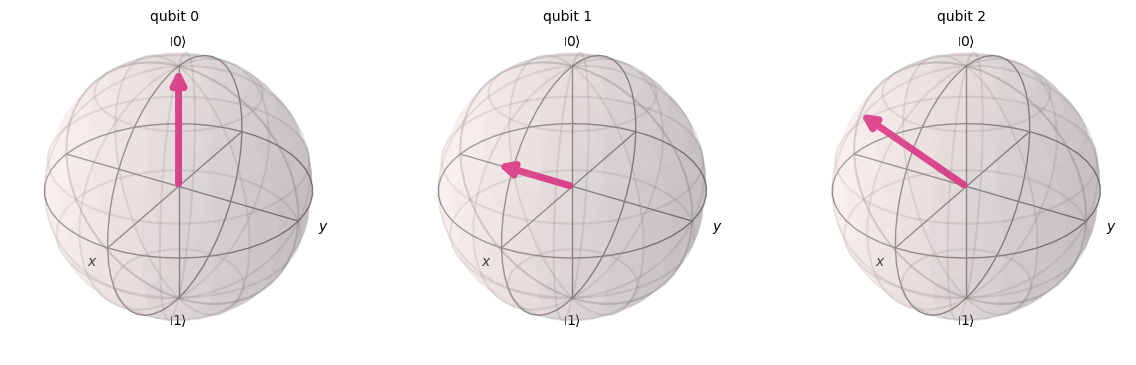

In [178]:
player = QuantumRegister(1, name='player')
n_starting_people = 2

network = QuantumRegister(n_starting_people, name='network')
bit = ClassicalRegister(1, name='bit')

qc = QuantumCircuit(player, network, bit)

# get the data
data = pd.read_csv('records.csv').to_numpy()
data = normalize_data(data)

# people considered in the network
people_we_consider = []

# creates random network starting states
def initial_state(n):
    temp = QuantumCircuit(n)
    for i in range(n):
        index = np.random.randint(0, len(data))
        people_we_consider.append(index)
        # cartesian to spherical
        theta = np.arctan(data[index][1] / data[index][0])
        phi = np.arccos(data[index][2] / np.linalg.norm(data[index]))
        temp.rx(theta, i)
        temp.ry(phi, i)
    return temp

# gives the people in the network the random starting positions
q2 = initial_state(n_starting_people)
q2.draw()
qc.compose(q2, np.arange(1, n_starting_people+1), inplace=True)

# debug 
qc.draw(output='mpl')
plot_bloch_multivector(qc)


# epochs = 10

# player_interactions = [(np.random.randint(0, n_starting_people+1)) for i ]

# for i in range (epochs):
    # s = input('interact with:')

# while True:

In [179]:
player_interactions = np.arange(1, n_starting_people+1)
np.random.shuffle(player_interactions)
print(player_interactions)

[1 2]


In [180]:
gates_types = ['crx', 'cry', 'crz']
gate = [np.random.choice(gates_types) for _ in range(n_starting_people)] # list of gates as str

circuits = [qc.copy() for _ in range(n_starting_people)]

for i, circ in enumerate(circuits):
    theta = np.random.uniform(0, np.pi)
    if gate[i] == 'crx':
        circ.crx(theta, network[i], player)
    elif gate[i] == 'cry':
        circ.cry(theta, network[i], player)
    else:
        circ.crz(theta, network[i], player)
    
    circ.measure(player, bit)
    print(circ)

                                         ┌─────────────┐┌─┐
   player: ──────────────────────────────┤ Ry(0.61928) ├┤M├
           ┌─────────────┐┌─────────────┐└──────┬──────┘└╥┘
network_0: ┤ Rx(0.15425) ├┤ Ry(0.98051) ├───────■────────╫─
           ├─────────────┤└┬────────────┤                ║ 
network_1: ┤ Rx(0.77698) ├─┤ Ry(0.5439) ├────────────────╫─
           └─────────────┘ └────────────┘                ║ 
    bit: 1/══════════════════════════════════════════════╩═
                                                         0 
                                         ┌────────────┐┌─┐
   player: ──────────────────────────────┤ Ry(2.6068) ├┤M├
           ┌─────────────┐┌─────────────┐└─────┬──────┘└╥┘
network_0: ┤ Rx(0.15425) ├┤ Ry(0.98051) ├──────┼────────╫─
           ├─────────────┤└┬────────────┤      │        ║ 
network_1: ┤ Rx(0.77698) ├─┤ Ry(0.5439) ├──────■────────╫─
           └─────────────┘ └────────────┘               ║ 
    bit: 1/════════════════════════════════════

In [181]:
# run the circuit
better_circuit = circ[0]
max_ = -1

index_of_person_who_in_cirrcuit = 0

for i, circ in enumerate(circuits):
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circ, backend)
    result = job.result()
    counts = result.get_counts()

    if counts['1'] > max_:
        max_ = counts['1']
        better_circuit = circ
        index_of_person_who_in_cirrcuit = i
    
    print(counts)

print(better_circuit)

# remove the person who is in the circuit from our data
data = np.delete(data, people_we_consider[index_of_person_who_in_cirrcuit], axis=0)

{'0': 1004, '1': 20}
{'0': 835, '1': 189}
                                         ┌────────────┐┌─┐
   player: ──────────────────────────────┤ Ry(2.6068) ├┤M├
           ┌─────────────┐┌─────────────┐└─────┬──────┘└╥┘
network_0: ┤ Rx(0.15425) ├┤ Ry(0.98051) ├──────┼────────╫─
           ├─────────────┤└┬────────────┤      │        ║ 
network_1: ┤ Rx(0.77698) ├─┤ Ry(0.5439) ├──────■────────╫─
           └─────────────┘ └────────────┘               ║ 
    bit: 1/═════════════════════════════════════════════╩═
                                                        0 


/var/folders/nn/kbg0q8s57494vm2z9d151d9m0000gn/T/ipykernel_22638/1396527169.py:6: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(circ, backend)


In [ ]:
# adding new people to the network
